In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Rating Data - 2017
Let's start with grabbing information from 2017. It's simple, complete, and needs minimal cleaning.

In [19]:
csv_2017 = pd.read_csv('2017/Student Feedback Surveys-Superview.csv')

def clean_week(input):
    return int(input[-1])

def clean_rating(input):
    try:
        rating = int(input)
        return rating
    except ValueError:
        return False

csv_2017.columns = ['ID', 'Location', 'Track', 'Week', 'Rating', 'Pacing']
csv_2017 = csv_2017.drop(columns=['Pacing'])
csv_2017['Week'] = csv_2017['Week'].apply(clean_week)
csv_2017['Rating'] = csv_2017['Rating'].apply(clean_rating)

## Mean Ratings and NPS
### NPS scores
#### Converting NPS Scores
Before we go anywhere, let's talk about NPS scores.

NPS scores are an indicator as to whether someone will be a promoter (+1, score 9-10), passive (0, 7-8), or a detractor (-1, <7) of your product.

Our current data does not have NPS scores, so we're going to make it ourselves by creating a function.

#### Observations
Below, we look for the average rating per week and the NPS scores. For now, let's use a simple lineplot. At first glance, nothing seems to stand out, with scores gradually going up with a small spike at 3.

In [26]:
"""Helper Functions"""

def find_means(data):
    points = []
    for i in range(1, 9):
        points.append(data[data["Week"] == i]["Rating"].mean())
    return np.array(points)

def find_nps_means(data):
    points = []
    for i in range(1, 9):
        points.append(data[data["Week"] == i]["NPS"].mean())
    return np.array(points)

def nps_convert(input):
    try:
        rating = int(input)
        if(rating <= 6):
            return -1
        elif(rating <= 8):
            return 0
        else:
            return 1
    except:
        return None

csv_2017['NPS'] = csv_2017['Rating'].apply(nps_convert)

Text(13.175,0.5,'Rating - NPS Mean')

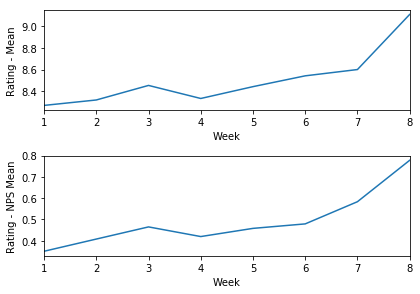

In [27]:
weeks=[i for i in range(1,9)]
ax1 = plt.subplot(211)
plt.tight_layout()
plt.plot(weeks, find_means(csv_2017))
plt.xlim(1,8)
plt.xlabel('Week')
plt.ylabel('Rating - Mean')

ax2 = plt.subplot(212)
plt.tight_layout()
plt.plot(weeks, find_nps_means(csv_2017))
plt.xlim(1,8)
plt.xlabel('Week')
plt.ylabel('Rating - NPS Mean')

### Ratings Per Week via Linear Regression

Let's try using a linear regression plot. With x-estimator, we can see that there's something going on with week 8. But what?

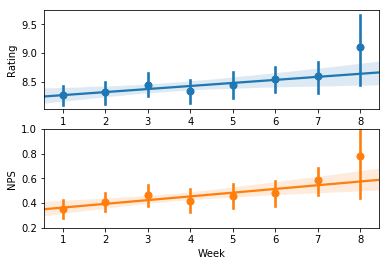

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1)

sns.regplot(x='Week', y='Rating', data=csv_2017, x_estimator=np.mean, ax=ax1)
sns.regplot(x='Week', y='NPS', data=csv_2017, x_estimator=np.mean, ax=ax2)
ax2.set_ylim(0.2, 1)

plt.show()


In [23]:
print("Let's look at the amount of values!\n")
for i in range(1,9):
    count = csv_2017[csv_2017["Week"] == i]["Rating"].count()
    print("Amount of values in Week {}: {} values".format(i, count))
    
print("\nWell, that seems off. It looks like there's only 9 values in the 8th week!")

Let's look at the amount of values!

Amount of values in Week 1: 288 values
Amount of values in Week 2: 277 values
Amount of values in Week 3: 243 values
Amount of values in Week 4: 193 values
Amount of values in Week 5: 179 values
Amount of values in Week 6: 144 values
Amount of values in Week 7: 120 values
Amount of values in Week 8: 9 values

Well, that seems off. It looks like there's only 9 values in the 8th week!


## Summer Academy Data - 2016
Now, a little tougher; let's try to find a way to pull all the mesh of data together from the .csvs

In [45]:
"""That's a mouthful!"""

import glob

def rating_reformat(rating, scale=10):
    # In case of errors
    try:
        return int(rating) * int(10 / scale)
    except: 
        return None
        
def week_cleaner(data, week, scale=10):
    # Priming renaming of columns
    rating_string1 = 'How would you rate your overall satisfaction with the Summer Academy this week?'
    rating_string2 = 'How likely is it that you would recommend the Make School Summer Academy to a friend?'
    pacing_string1 = 'How well are the tutorials paced?'
    pacing_string2 = 'How well is the schedule paced?'
    track_string = 'What track are you in?'
    
    # Let's rename the columns
    rename = { rating_string1:'Rating', rating_string2:'Rating', pacing_string1:'Pacing', \
              pacing_string2:'Pacing', track_string:'Track'}
    data = data.rename(columns=rename)
    
    # New columns: keep track of week, rework rating, create NPS
    data['Week'] = week
    data['Rating'] = data['Rating'].apply(rating_reformat, scale=scale)
    data['NPS'] = data['Rating'].apply(nps_convert)
    
    # Insert what rows are irrelevant here
    drop = []
    if 'Pacing' in data.columns:
        drop.append('Pacing')
    if 'Timestamp' in data.columns:
        drop.append('Timestamp')
    if 'Unnamed: 0' in data.columns:
        drop.append('Unnamed: 0')
    if 'location' in data.columns:
        drop.append('location')
    if 'Track' in data.columns:
        drop.append('Track')
    
    data = data.drop(columns=drop)

    return data

week_csv = [[] for _ in range(8)]

for i in range(1, 8):
    # Go through every csv; preformatted
    weekly_csv_filenames = glob.glob('2016/Anon Week {}*.csv'.format(i))
    week_csv[i-1] = []

    # Add each one 
    for location in weekly_csv_filenames:
        data = pd.read_csv(location)
        week_csv[i-1].append(week_cleaner(data, week=i, scale=5))
    
    week_csv[i-1] = pd.concat(week_csv[i-1], sort=True)

# This one needs some special consideration due to the formatting
week8 = pd.read_csv('2016/Week 8 Feedback (2016, incomplete) - results.csv')
week8 = week8.drop(columns=['#', 'track', 'Network ID', 'Start Date (UTC)', 'Submit Date (UTC)'])
week_csv[7] = week_cleaner(week8, week=8)

csv_2016 = pd.concat(week_csv, sort=True, ignore_index=True)

Text(13.175,0.5,'Rating - NPS Mean')

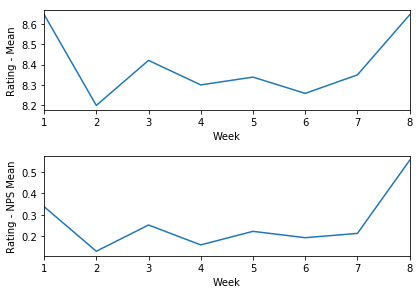

In [46]:
# For x-axis
ax1 = plt.subplot(211)
plt.tight_layout()
plt.plot(weeks, find_means(csv_2016))
plt.xlim(1,8)
plt.xlabel('Week')
plt.ylabel('Rating - Mean')

ax2 = plt.subplot(212)
plt.tight_layout()
plt.plot(weeks, find_nps_means(csv_2016))
plt.xlim(1,8)
plt.xlabel('Week')
plt.ylabel('Rating - NPS Mean')

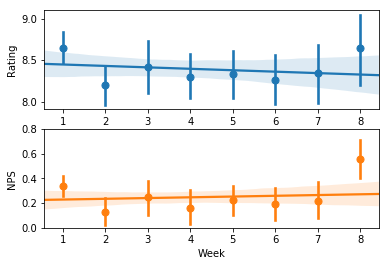

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1)

sns.regplot(x='Week', y='Rating', data=csv_2016, x_estimator=np.mean, ax=ax1)
sns.regplot(x='Week', y='NPS', data=csv_2016, x_estimator=np.mean, ax=ax2)
ax2.set_ylim(0, 0.8)

plt.show()


## Final Showing
Let's compare and contrast!

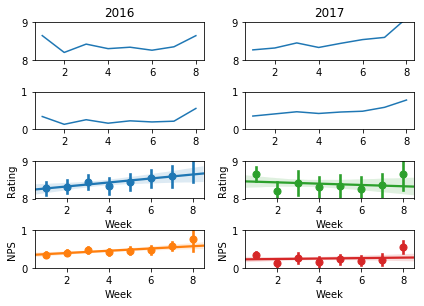

In [133]:
fig, ax = plt.subplots(nrows=4, ncols=2)

plt.tight_layout()
ax[0][0].set_title("2016")
# Mean - Line
ax[0][0].set_ylim(8,9)
ax[0][0].plot(weeks, find_means(csv_2016))
# NPS - Line
ax[1][0].set_ylim(0,1)
ax[1][0].plot(weeks, find_nps_means(csv_2016))
# Mean - Reg
ax[2][0].set_ylim(8,9)
sns.regplot(x='Week', y='Rating', data=csv_2017, x_estimator=np.mean, ax=ax[2][0])
# NPS - Reg
ax[3][0].set_ylim(0,1)
sns.regplot(x='Week', y='NPS', data=csv_2017, x_estimator=np.mean, ax=ax[3][0])

# 2017
ax[0][1].set_title("2017")
# Mean - Line
ax[0][1].set_ylim(8,9)
ax[0][1].plot(weeks, find_means(csv_2017))
# NPS - Line
ax[1][1].set_ylim(0,1)
ax[1][1].plot(weeks, find_nps_means(csv_2017))
# Mean - Reg
ax[2][1].set_ylim(8,9)
sns.regplot(x='Week', y='Rating', data=csv_2016, x_estimator=np.mean, ax=ax[2][1])
# NPS - Reg
ax[3][1].set_ylim(0,1)
sns.regplot(x='Week', y='NPS', data=csv_2016, x_estimator=np.mean, ax=ax[3][1])